# Background


## Motivation
Sometimes we love a song for its haunting melodies and sometimes because the lyrics resonate with us deeply. It would be really cool to build a recommender system where users discover new music and musicians based on song topics! 
## Questions    
To learn "topics" from lyrics, we can use an unsupervised machine learning technique, [topic modeling](https://en.wikipedia.org/wiki/Topic_model). In this project, I'm using my favorite band [Nightwish](https://nightwish.com/) as a case study. In their 24-year career, this Finnish symphonic metal band has explored a wide variety of topics, from love and betrayal to evolution and space exploration. First of all, I'll use topic modeling to **discover the topic of each Nightwish song**. Then based on that, I'll examine how the **proportion of each topic in each Nightwish albums** has changed over time.

## Data
I scraped all of Nightwish's lyrics from [Dark Lyrics](http://www.darklyrics.com/) and shared the data on my [Kaggle](https://www.kaggle.com/crazyrichbayesians/nightwish-lyrics) page. The raw data is a plain text file where each album title is followed by the lyrics of each song from that album. I converted the raw data into a date frame where each row is a line of lyric, with columns indicating the song, the album, and the year where that line comes from. As is standard for a natural language processing project like this, I then cleaned the text data in the following ways:

1. **Lower-casing**: Converted all letters to lower case.
2. **Normalization**: Expanded contractions (e.g., I've → I have), removed punctuations and special characters, converted accented letters to unaccented letters (e.g., é → e), replaced potential typos with the most likely correct spellings, and stripped extra spaces between words.
3. **Stopword removal**: Removed common words that don't bear too much meaning, such as pronouns (e.g., I, its, yourself, etc.), determiners (e.g., a, the), conjunctions (e.g., for, an, nor, but, or, yet, so), and prepositions (e.g., in, under, towards, before).
4. **Lemmatization**: Returned each word to its [lemma](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) or "base form" (e.g., wants, wanted → want).

Since the above preprocessing steps take a lot of time and space, I documented the whole process in an [another notebook](https://github.com/Yuan-Meng/nightwish/blob/master/nightwish_clean.ipynb). In this notebook, I'll load the data I've already preprocessed for exploratory data analysis and topic modeling.

# Preprocessing 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter
import spacy
import en_core_web_lg
import gensim
from gensim import corpora, models
from gensim.models import word2vec, CoherenceModel
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
import hdbscan
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import clean
import word_2dviz

pd.options.mode.chained_assignment = None
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

import warnings

warnings.filterwarnings("ignore")

%load_ext lab_black

## Load data
Read the clean data from a CSV file saved before.

In [2]:
# Read from CSV
df = pd.read_csv("nightwish_lyrics.csv")

# Drop rows that no longer have lyrics
df_clean = df.dropna()

# Inspect first few rows
df_clean.head()

,lyric,album_title,year,track_title,track_number,lyric_normalized,lyric_nostop,lyric_lemma
0,The ticktock of time allows me to see,Nightwish,1996,The Forever Moments,1,the tick tock of time allows me to see,tick tock time allows,tick tock time allow
1,An authent to an echo,Nightwish,1996,The Forever Moments,1,an athens to an echo,athens echo,athens echo
2,New butterfly to a cocoon,Nightwish,1996,The Forever Moments,1,new butterfly to a cocoon,new butterfly cocoon,new butterfly cocoon
3,The swan to ugly duckling,Nightwish,1996,The Forever Moments,1,the swan to ugly duckling,swan ugly duckling,swan ugly duckling
4,The lake to an ocean,Nightwish,1996,The Forever Moments,1,the lake to an ocean,lake ocean,lake ocean


## Aggregate by song
Since I care about the topic of each song rather than each line, first make sure that each row is a song.

In [3]:
# Aggregate lyrics by song
df_song = (
    df_clean.groupby(["track_title"])["lyric_lemma"]
    .apply(lambda x: " ".join(x))
    .reset_index()
)

#  JOIN df_song with df_clean for album title and year
df_merged = df_song.merge(
    df_clean[["track_title", "album_title", "year"]],
    on="track_title",
    validate="one_to_many",
)

# Drop duplicated rows
df_merged.drop_duplicates(inplace=True)

# Reset index
df_merged.reset_index(inplace=True)

# Inspect first few rows
df_merged.head()

,index,track_title,lyric_lemma,album_title,year
0,0,7 Day To The Wolves,wolf love come take home dust man life death l...,Dark Passion Play,2007
1,21,A Return To The Sea,star fall darken sky new world bear die kingdo...,Angels Fall First,1997
2,44,All the Works of Nature Which Adorn the World,look dot home love know hear human live life a...,Hvman. :||: Natvre.,2020
3,51,All the Works of Nature Which Adorn the World,look dot home love know hear human live life a...,Non-Album,Unknown Year
4,70,Alpenglow,time song hear give birth child earth verse sl...,Endless Forms Most Beautiful,2015


Now the data is at the desired level of granularity.

## Studio album only
Since I want to analyze how Nightwish's overall topics change from one album to another, I'll include only studio albums and drop singles and live albums. The latter two have two few songs and the songs in them are usually also in studio albums.

In [4]:
# List of studio albumns by Nightwish in chronological order
studio_albums = [
    "Angels Fall First",
    "Oceanborn",
    "Wishmaster",
    "Century Child",
    "Once",
    "Dark Passion Play",
    "Imaginaerum",
    "Hvman. :||: Natvre.",
]

# Only keep in-album songs
df_merged = df_merged.loc[df_merged["album_title"].isin(studio_albums)]

# Reset index
df_merged.reset_index(inplace=True)

# Drop extra columns
df_merged.drop(["level_0", "index"], axis=1, inplace=True)

## Text cleaning

### Stopword removal
I've already removed common stopwords from the lyrics. However, after glancing at the results, there seem to be a few more to get rid of.

In [5]:
# Manually filter out more stopwords
filter = ["s", "oh", "ah", "o", "e", "ee", "ieee", "let", "come"]

lyrics_clean = []

for lyric in df_merged["lyric_lemma"]:
    lyric_list_clean = [word for word in lyric.split() if word not in filter]
    lyric_clean = " ".join(lyric_list_clean)
    lyrics_clean.append(lyric_clean)

df_merged["lyric_lemma"] = lyrics_clean

### Tokenization
For topic modeling, the desired input is a list of lists, where each sublist is a document (i.e., a song) and each item is a word token.

In [6]:
# Tokenize words
lyrics = df_merged["lyric_lemma"].tolist()
lyrics = [i for i in lyrics if i]  # Remove empty strings
tokens = [lyric.split() for lyric in lyrics]

## Word embeddings
Machines don't understand words, obviously, so we need to convert tokens into numerics which can be used as input. The process of creating numeric vectors from text data is called word embedding. For topic modeling, the "context" in which a word appears doesn't matter too much; in this case, the most popular techniques are Bag-of-Words (BoW) and Term Frequency-Inverse Document Frequency (TF-IDF).

### BoW
BoW uses each unique word in the vocabulary as a binary feature and each sentence is represented as having or not having each feature. The upside of BoW is that it's easy to interpret and the drawbacks are that the feature space increases quickly with the vocabulary size and the resulting matrix is often so sparse (containing lots of 0's) that it's quite computationally expensive.

In [7]:
# Filter out words that are too rare or too common
dictionary = corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=10, no_above=0.5)

# Create a bag of words
corpus_bow = [dictionary.doc2bow(token) for token in tokens]

### TF-IDF
Rather than treating each word as equal, TF-IDF assigns higher values to more "important" words. So what's considered important? First of all, important words appear often. This is captured by the "TF" part in TF-IDF, which is "term frequency" or how many times a token appears in a document divided by the document length. However, words (e.g., "this") found across many documents are often mundane and lack unique contributions. The "inverse document frequency (IDF)" part in TF-IDF, i.e. $\log\frac{\#\;\mathrm{of}\;\mathrm{docs}}{\#\;\mathrm{of}\;\mathrm{docs}\;\mathrm{with}\;\mathrm{given}\;\mathrm{token}}$, discounts the importance of such words. Each word's importance, as measured by its TF-IDF score, is the product of these two factors: TF-IDF = TF $\times$ IDF.

In [8]:
# Create TF-IDF
tfidf = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

Topic models built on TF-IDF usually perform better than those built on BoW. Let's try and compare both approaches below.

# Exploratory data analysis
As a longtime Nightwish fan, I noticed that they use some words quite a lot, such as "angel" "night" "innocence", etc. I also feel that the most used words vary from album to album. Let's first look at the overall trend across all albums and compare that between albums.

## Popular words across albums

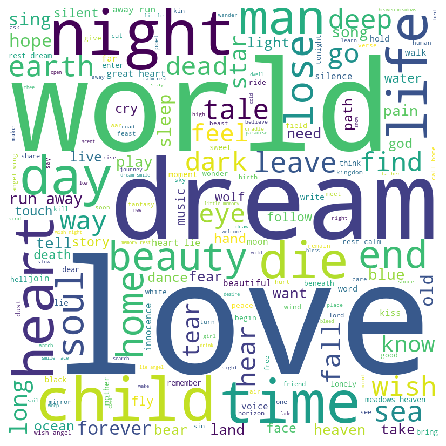

In [9]:
# Generate a word cloud
tokens_flat = [item for items in tokens for item in items]
common_words = " ".join(tokens_flat) + " "

wordcloud = WordCloud(width=800, height=800, background_color="white").generate(
    common_words
)

plt.figure(figsize=(6, 6), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

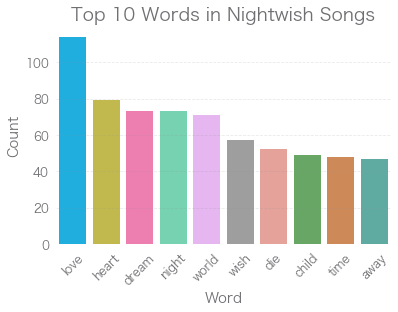

In [10]:
# Generate a bar plot
# Count each word's frequency
dict_freq = Counter(tokens_flat)
df_freq = pd.DataFrame.from_dict(dict_freq, orient="index").reset_index()
df_freq = df_freq.rename(columns={"index": "word", 0: "count"})

# Plot frequencies of top 10 words
top10 = df_freq.sort_values(by=["count"], ascending=False)[0:10]

sns.barplot(x="word", y="count", data=top10)
plt.title("Top 10 Words in Nightwish Songs")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Words used most frequently in Nightwish's songs are "love" "heart" "dream" "world" "child" as well as their namesake "night" and "wish". This pretty much aligns with my impression of the song writer, Tuomas Holopainen, who often dreams of childhood and is in love with the night.

## Album comparison

In [11]:
# Count word frequencies in each album
df_freq_list = []

for album in studio_albums:

    # Extract rows for each album
    album_lyrics = df_merged.loc[
        df_merged["album_title"] == album, "lyric_lemma"
    ].tolist()

    # Tokenize words
    album_tokens = [album_lyrics.split() for album_lyrics in album_lyrics]

    # Flatten the list
    album_tokens_flat = [item for items in album_tokens for item in items]

    # Count each word's frequency
    album_dict_freq = Counter(album_tokens_flat)
    album_df_freq = pd.DataFrame.from_dict(
        album_dict_freq, orient="index"
    ).reset_index()
    album_df_freq = album_df_freq.rename(columns={"index": "word", 0: "count"})
    album_df_freq["album_title"] = album

    df_freq_list.append(album_df_freq)

album_freq = pd.concat(df_freq_list)

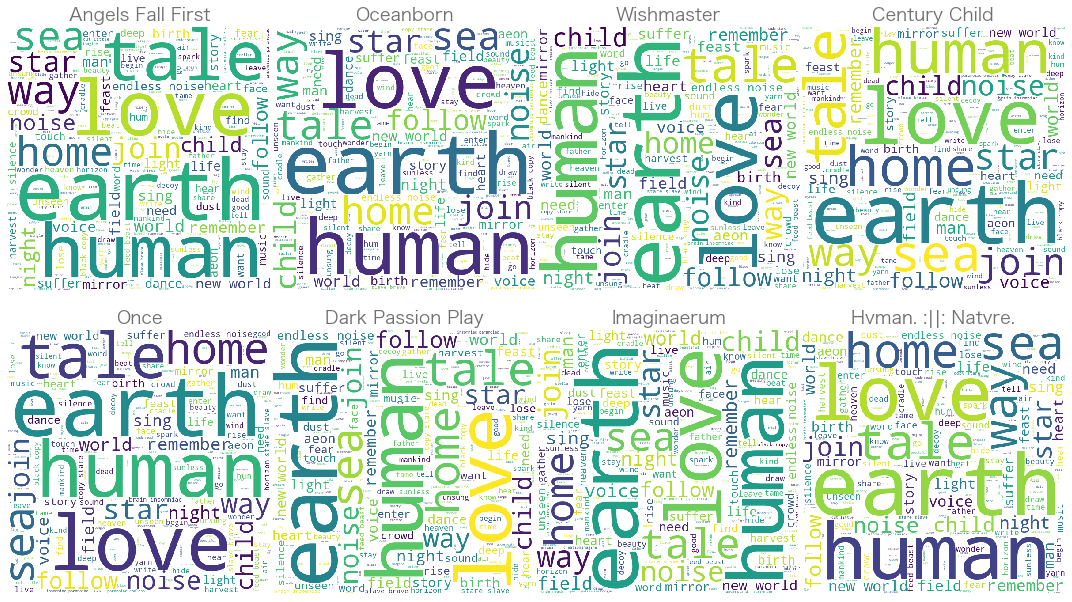

In [12]:
# Word cloud
plt.figure(figsize=(15, 9))

for idx, album in enumerate(studio_albums):

    # Tokenize words
    album_tokens = [album_lyrics.split() for album_lyrics in album_lyrics]

    # Flatten the list
    album_tokens_flat = [item for items in album_tokens for item in items]

    # Generate a word cloud
    album_common_words = " ".join(album_tokens_flat) + " "

    album_wordcloud = WordCloud(
        width=600, height=600, background_color="white"
    ).generate(album_common_words)

    plt.subplot(2, 4, idx + 1)
    plt.imshow(album_wordcloud)
    plt.title(f"{album}")
    plt.axis("off")

plt.tight_layout(h_pad=0, w_pad=0)
plt.show()

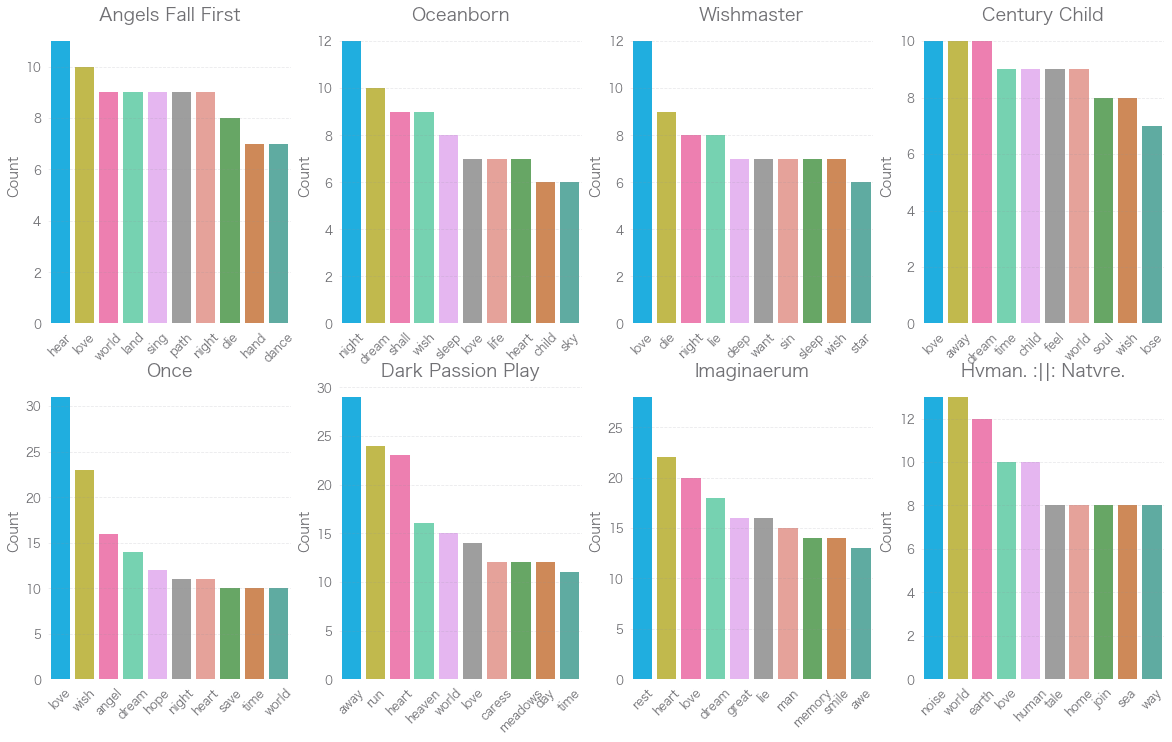

In [13]:
# Plot top 15 words in each album
plt.figure(figsize=(20, 12))

for idx, album in enumerate(studio_albums):

    plt.subplot(2, 4, idx + 1)

    # Top 10 words in each album
    album_top10 = album_freq.loc[album_freq["album_title"] == album].sort_values(
        by=["count"], ascending=False
    )[0:10]

    # Plot
    sns.barplot(x="word", y="count", data=album_top10)
    plt.title(f"{album}")
    plt.xlabel("")
    plt.ylabel("Count")
    plt.xticks(rotation=45)

plt.tight_layout
plt.show()

Nightwish's favorite words (e.g., "night" "love" "heart", etc.) seem pretty consistent over the years. Upon closer look, there are some subtle changes. For instance, their latest album *Human. :||: Nature.* talks more about nature (e.g., "earth" "sea", etc.) whereas the previous ablum *Imaginaerum* more about personal feelings (e.g., "heart" "memory" "awe"). Let's see if topic models can capture those changes.

# Topic modeling
Among various [topic modeling algorithms](https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05), latent Dirichlet allocation (LDA) is the most widely used, which maps documents (songs) with a list of topics via Bayesian inference. I'll use LDA to identify the dominant topic of each Nightwish song.

## Custom functions

In [14]:
# Find topics across songs
def lda_model(n_topic, corpus):

    # Run LDA
    ldamodel = gensim.models.LdaModel(
        corpus,
        num_topics=n_topic,
        #         alpha="auto",
        #         eta="auto",
        id2word=dictionary,
        passes=10,
        random_state=100,
    )

    # Return model
    return ldamodel

In [15]:
# Tune the number of topics to maximize coherence
def tune_num_topics(corpus):

    # Try 1 to 10 tipics
    coherence_cv = []
    list_n = list(range(1, 11))

    for n in list_n:
        # LDA model
        model = lda_model(n, corpus)
        # Coherence scores
        coherence_model_lda = CoherenceModel(
            model=model, texts=tokens, dictionary=dictionary, coherence="c_v"
        )
        coherence_cv.append(coherence_model_lda.get_coherence())

    # Plot coherence against num_topics
    plt.figure(figsize=(6, 6))
    plt.plot(list_n, coherence_cv, "-o")
    plt.xlabel(r"Number of topics")
    plt.xticks(np.arange(0, 11, step=1))
    plt.ylabel("Coherence score")
    plt.show()

In [16]:
# Identify dominant topic of each song
def dominant_topic(ldamodel, corpus, texts):

    topics_df = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num, topn=4)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_df = topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]),
                    ignore_index=True,
                )
            else:

                break

    topics_df.columns = ["dominant_topic", "perc_contribution", "topic_keywords"]
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)

    return topics_df

In [17]:
# Find proportion of each topic in each album
def song_topic(ldamodel, corpus, topic_list):

    # Identify dominant topic of each song
    df_topic = dominant_topic(
        ldamodel=ldamodel, corpus=corpus, texts=df_merged["lyric_lemma"]
    )  # Use "df_merged["lyric_lemma"]"  rather than "tokens" for column title

    # Pull album info
    df_topic = df_topic.merge(df_merged, on="lyric_lemma")

    # Label topics
    topic_num = df_topic["dominant_topic"].unique().tolist()
    df_topic["topic_label"] = df_topic["dominant_topic"].replace(
        dict(zip(topic_num, topic_list))
    )

    # Percentage of each topic in each album
    df_perc = pd.crosstab(df_topic["album_title"], df_topic["topic_label"]).apply(
        lambda row: row / row.sum(), axis=1
    )

    # Reshape data
    df_perc["album"] = df_perc.index

    df_perc_melt = pd.melt(
        df_perc,
        id_vars=["album"],
        value_vars=df_perc.columns[:-1].tolist(),
        var_name="topic",
        value_name="perc",
    )

    return df_perc_melt

In [18]:
# Visualize topic change over the years
def topic_by_album(df_melt):
    # Sort by album release order
    sorterIndex = dict(zip(studio_albums, range(len(studio_albums))))
    df_melt["album_order"] = df_melt["album"].map(sorterIndex)
    df_melt.sort_values(["album_order"], ascending=True, inplace=True)
    df_melt.drop("album_order", axis=1, inplace=True)

    # Lineplot
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="album", y="perc", hue="topic", data=df_melt, sort=False)
    plt.xlabel("Album")
    plt.xticks(rotation=90)
    plt.ylabel("Proportion")
    plt.legend(bbox_to_anchor=(1.0, 0.9), loc=2, borderaxespad=0.0)
    plt.show()

## LDA on bag of words

### Hyperparameter tuning

Topic models based on LDA have several [hyperparameters](https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/), including the total number of topics in the corpus, document-topic density ($\alpha$), and topic-word density ($\beta$). Using the library Genism, we can infer $\alpha$ and $\beta$ (called `eta` in Genism) automatically from data. All we need to tune manually is the number of topics. Let's try 1 to 10 topics and evaluate model performance using "topic coherence". Coherence measures semantic similarity between high scoring words in a given topic; higher coherence is better.

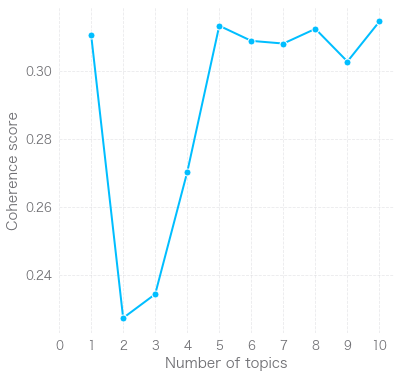

In [19]:
tune_num_topics(corpus_bow)

For BoW, coherence is the highest when there are 5 models. Let's train our final model this way.

In [20]:
# Run LDA on BoW
ldamodel_bow = lda_model(5, corpus_bow)

This next step is more art than science, that is, giving a name to each topic found by LDA.

In [21]:
# Show topics
for idx, topic in ldamodel_bow.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic} \n")

Topic: 0 
Words: 0.053*"world" + 0.034*"dead" + 0.027*"home" + 0.027*"soul" + 0.027*"cry" + 0.026*"die" + 0.025*"day" + 0.025*"tell" + 0.024*"life" + 0.021*"beauty" 

Topic: 1 
Words: 0.042*"heart" + 0.037*"time" + 0.026*"child" + 0.025*"night" + 0.021*"tale" + 0.021*"land" + 0.019*"tear" + 0.019*"hear" + 0.017*"end" + 0.017*"world" 

Topic: 2 
Words: 0.084*"rest" + 0.074*"dream" + 0.049*"home" + 0.047*"world" + 0.033*"little" + 0.032*"call" + 0.031*"face" + 0.030*"voice" + 0.029*"blue" + 0.029*"earth" 

Topic: 3 
Words: 0.063*"lie" + 0.058*"die" + 0.053*"heart" + 0.053*"angel" + 0.046*"great" + 0.043*"heaven" + 0.036*"wish" + 0.030*"old" + 0.028*"deep" + 0.025*"man" 

Topic: 4 
Words: 0.088*"away" + 0.068*"wish" + 0.068*"night" + 0.063*"dream" + 0.038*"star" + 0.038*"lose" + 0.033*"wonder" + 0.027*"dark" + 0.027*"want" + 0.027*"live" 



Te `pyLDAvis` library allows us to view words in each topic ranked by importance as well as the distance between topics.

In [22]:
# Visualize results
lda_bow_display = pyLDAvis.gensim.prepare(
    ldamodel_bow, corpus_bow, dictionary, sort_topics=False
)

lda_bow_display  # In another tab: pyLDAvis.show(lda_bow_display)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.001106 -0.045876       1        1  20.888428
1      0.018568 -0.024770       2        1  37.980522
2      0.165708 -0.022447       3        1  11.240247
3     -0.143351 -0.080370       4        1  16.190037
4     -0.042031  0.173464       5        1  13.700760, topic_info=     Term       Freq      Total Category  logprob  loglift
65   away  46.000000  46.000000  Default  30.0000  30.0000
4   dream  70.000000  70.000000  Default  29.0000  29.0000
15   rest  40.000000  40.000000  Default  28.0000  28.0000
93   wish  55.000000  55.000000  Default  27.0000  27.0000
78    lie  44.000000  44.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
78    lie   6.266120  44.590984   Topic5  -4.0947   0.0253
43   soul   4.953413  35.292427   Topic5  -4.3297   0.0241
80   find   4.183573  27.935057   Topic5  -4.4987   0.0890
9    life   4.269461  39.791950   Topic5  -4.4783  -0.2445
46  white   3.177886  25.151947   Topic5  -4.7736  -0.0810

[215 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
56        2  0.184468  angel
56        3  0.061489  angel
56        4  0.707129  angel
56        5  0.061489  angel
65        1  0.214484   away
...     ...       ...    ...
32        1  0.429527  world
32        2  0.257716  world
32        3  0.214763  world
32        4  0.071588  world
32        5  0.028635  world

[401 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

We can name the topics as follows:

In [23]:
# Topics found in bag of words
topics_bow = [
    "pain & sorrow",
    "childhood & fantasies",
    "nature & wanderlust",
    "angels & heaven",
    "dreams & wishes",
]

### Topic change over the years

In [24]:
# Proportion of each topic in each album
df_bow = song_topic(ldamodel_bow, corpus_bow, topics_bow)

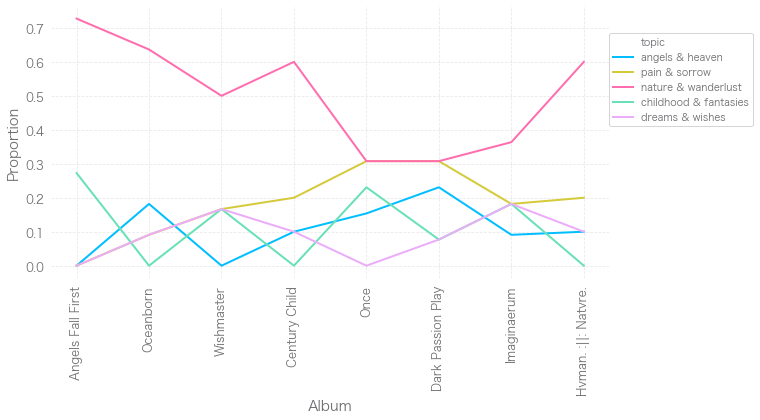

In [25]:
# Visualize the change
topic_by_album(df_bow)

Across all Nightwish albums, the most common topic is nature and wanderlust. The popularity of this topic peaked in their first album, declined over the years (except for a small peak in *Century Child*), and climbed up again in the newest album. In *Once* and *Dark Passion Play*, Tuomas also talked a lot about pain and sorrow, which coincided with the most difficult period of his life where the lead singer and his childhood friend Tarja Turunen left the band. All in all, this topic model aligns well with my intuitions about Nightwish.

## LDA on TF-IDF

### Hyperparameter tuning

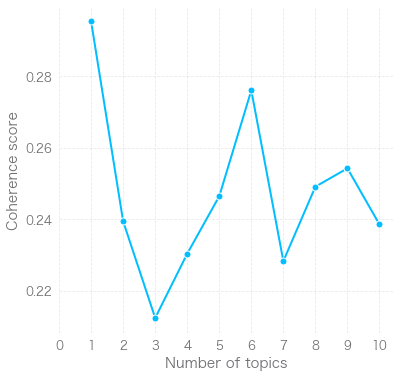

In [26]:
tune_num_topics(corpus_tfidf)

Coherence is the highest when there is just one topic. However, we can't analyze topic changes over the years without having multiple topics. To that end, I'll train the topic model with 6 topics, which yields the second highest topic coherence.

In [27]:
# Run LDA on TF-IDF
ldamodel_tfidf = lda_model(6, corpus_tfidf)

In [28]:
# Show topics
for idx, topic in ldamodel_tfidf.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic} \n")

Topic: 0 
Words: 0.041*"away" + 0.035*"wind" + 0.035*"land" + 0.029*"hear" + 0.024*"turn" + 0.022*"play" + 0.021*"call" + 0.020*"hand" + 0.019*"moon" + 0.019*"moment" 

Topic: 1 
Words: 0.017*"hope" + 0.017*"dream" + 0.017*"night" + 0.017*"heart" + 0.016*"end" + 0.016*"shall" + 0.015*"earth" + 0.015*"child" + 0.015*"face" + 0.014*"leave" 

Topic: 2 
Words: 0.025*"think" + 0.024*"sing" + 0.024*"begin" + 0.024*"god" + 0.023*"good" + 0.022*"word" + 0.021*"like" + 0.020*"tale" + 0.020*"find" + 0.018*"man" 

Topic: 3 
Words: 0.038*"deep" + 0.027*"need" + 0.026*"lie" + 0.026*"join" + 0.025*"rest" + 0.025*"touch" + 0.023*"think" + 0.022*"die" + 0.022*"old" + 0.022*"angel" 

Topic: 4 
Words: 0.032*"want" + 0.027*"wonder" + 0.017*"lose" + 0.017*"wish" + 0.016*"live" + 0.014*"night" + 0.012*"star" + 0.012*"take" + 0.011*"story" + 0.011*"voice" 

Topic: 5 
Words: 0.024*"time" + 0.023*"beautiful" + 0.023*"world" + 0.022*"play" + 0.021*"soul" + 0.021*"heaven" + 0.020*"blue" + 0.019*"go" + 0.018*"wa

In [29]:
# Visualize results
lda_tfidf_display = pyLDAvis.gensim.prepare(
    ldamodel_tfidf, corpus_tfidf, dictionary, sort_topics=False
)

lda_tfidf_display  # In another tab: pyLDAvis.show(lda_tfidf_display)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.006316  0.033188       1        1   4.709859
1     -0.010901  0.031849       2        1  54.875172
2      0.001713  0.003173       3        1   4.177423
3     -0.059162 -0.034174       4        1   8.114134
4      0.008138  0.001208       5        1   3.479872
5      0.053897 -0.035244       6        1  24.643534, topic_info=     Term      Freq     Total Category  logprob  loglift
65   away  4.000000  4.000000  Default  30.0000  30.0000
50   land  3.000000  3.000000  Default  29.0000  29.0000
83   want  3.000000  3.000000  Default  28.0000  28.0000
62   sing  3.000000  3.000000  Default  27.0000  27.0000
84   wind  2.000000  2.000000  Default  26.0000  26.0000
..    ...       ...       ...      ...      ...      ...
13    man  1.073456  3.497542   Topic6  -4.3588   0.2195
65   away  1.177695  4.181072   Topic6  -4.2661   0.1336
0   child  1.243054  4.698091   Topic6  -4.2121   0.0711
9    life  1.087086  3.632387   Topic6  -4.3461   0.1943
66  earth  1.160808  4.441766   Topic6  -4.2805   0.0587

[271 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
56        2  0.590547   angel
56        4  0.295274   angel
65        1  0.239173    away
65        2  0.478346    away
65        6  0.239173    away
...     ...       ...     ...
104       6  0.385070  wonder
64        2  0.402688    word
64        6  0.402688    word
32        2  0.446116   world
32        6  0.446116   world

[188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

We can name the topics as follows:

In [30]:
# Topics found in TF-IDF
topics_tfidf = ["nature", "dream", "heaven", "emotion", "desire", "fantasy"]

### Topic change over the years

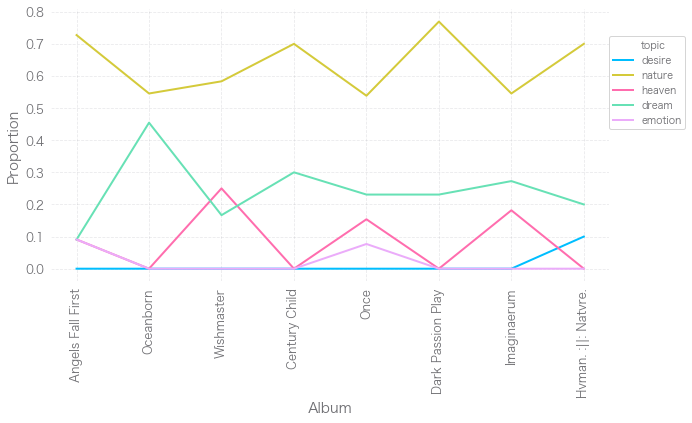

In [31]:
# Proportion of each topic in each album
df_tfidf = song_topic(ldamodel_tfidf, corpus_tfidf, topics_tfidf)

# Visualize it
topic_by_album(df_tfidf)

Topics discovered based on TF-IDF are slightly differ from those based on BoW. That said, similarities are striking: Nature is the most popular topic in all of Nightwish's albums, followed by dreams and heaven. Other topics appeared rather infrequently.

# Summary
Topic models are a quick away to learn what's going on in a large number of documents. Using this technique, I analyzed topics in my favorite band Nightwish's lyrics. After identifying the dominant topic in each song, I looked at how the proportion of each topic changed from one album to another. The results al